# Clase 4: Support Vector Machines

El objetivo de este ejercicio es consolidar la comprensión intuitiva de las SVM, y aprender experimentalmente a ajustar un modelo SVM.

*(Original adaptado del curso "Machine Learning" de Andrew NG, adaptado del material del curso "Aprendizaje Automático" de Cesar Olivares)*

## 1. SVM con kernel lineal

Empecemos con un conjunto de datos en 2D completamente separable por una frontera de decisión lineal. Importaremos los datos como un [`pandas.DataFrame`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!wget 'https://drive.google.com/uc?export=download&id=19UGsjpICqXoTPqEsNUm7DDBlXkSQKtwl' -O ex6data1.csv
!wget 'https://drive.google.com/uc?export=download&id=1ISGGxpdb6YvrvWBCAzDzbUYN22y40oVg' -O ex6data2.csv
!wget 'https://drive.google.com/uc?export=download&id=1TTiu1cgekgb4b8YxsNGLM7NQAeUrdFaM' -O ex6data3val.csv
!wget 'https://drive.google.com/uc?export=download&id=1Jdz777tTPUf6ctCKe98WX0cjd4Rfsfjk' -O ex6data3train.csv

--2020-10-15 02:27:56--  https://drive.google.com/uc?export=download&id=19UGsjpICqXoTPqEsNUm7DDBlXkSQKtwl
Resolving drive.google.com (drive.google.com)... 172.217.203.102, 172.217.203.100, 172.217.203.101, ...
Connecting to drive.google.com (drive.google.com)|172.217.203.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-3c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9miou2a1nijt9vr822ccc2f8sr6ugmf2/1602728850000/13307417494834192396/*/19UGsjpICqXoTPqEsNUm7DDBlXkSQKtwl?e=download [following]
--2020-10-15 02:27:57--  https://doc-10-3c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9miou2a1nijt9vr822ccc2f8sr6ugmf2/1602728850000/13307417494834192396/*/19UGsjpICqXoTPqEsNUm7DDBlXkSQKtwl?e=download
Resolving doc-10-3c-docs.googleusercontent.com (doc-10-3c-docs.googleusercontent.com)... 172.217.204.132, 2607:f8b0:400c:c15::84
Connecting to doc-10-3c-docs.googleusercontent.com (d

In [3]:
data1 = pd.read_csv('ex6data1.csv', names=['x1', 'x2', 'y'])

Siempre es bueno hacernos una idea inicial de los datos. Veamos sus principales parámetros estadísticos:

In [4]:
# Mostrar estadistica descriptiva
data1.describe()

,x1,x2,y
count,51.000000,51.000000,51.000000
mean,2.268780,3.132512,0.411765
std,0.928531,0.753256,0.497050
min,0.086405,1.617700,0.000000
25%,1.572550,2.636000,0.000000
50%,2.275300,3.070900,0.000000
75%,2.955050,3.531400,1.000000
max,4.015000,4.616200,1.000000


Veamos ahora los primeros 5 del total de 51 elementos:

In [5]:
# Mostrar los primeros 5 elementos del conjunto de datos
data1.head()

,x1,x2,y
0,1.9643,4.5957,1
1,2.2753,3.8589,1
2,2.9781,4.5651,1
3,2.9320,3.5519,1
4,3.5772,2.8560,1


También es posible mostrar fácilmente diagramas de caja:

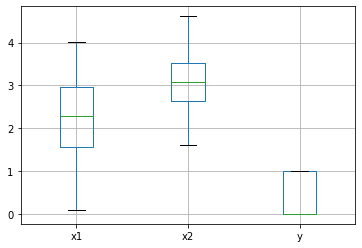

In [7]:
data1.boxplot(return_type='axes')

Para mayor claridad, separaremos $X$ y $y$.

In [8]:
X = data1[['x1', 'x2']]
y = data1['y']

Veamos también la distribución de valores $y$:

Distribución de valores de y:
0    30
1    21
Name: y, dtype: int64


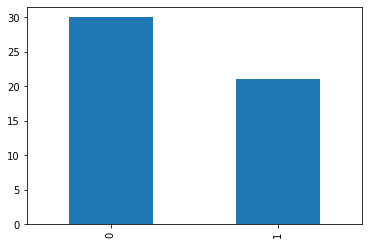

In [9]:
print( 'Distribución de valores de y:' )
print( data1['y'].value_counts() )

data1['y'].value_counts().plot.bar()

Visualicemos $X$ en un diagrama de dispersión, usando colores para distinguir las etiquetas de clase $y \in [0, 1]$ con los colores rojo $(0)$ y verde $(1)$:

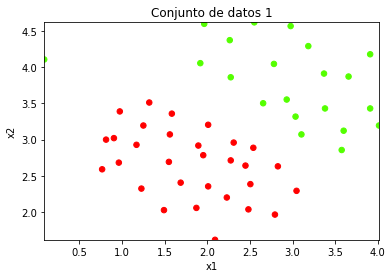

In [10]:
plt.title('Conjunto de datos 1')
plt.margins(x=0, y=0)
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(X['x1'], X['x2'], c=y, s=30, cmap='prism');

En este conjunto de datos, la posición de los ejemplos sugiere una separación natural, un espacio o brecha entre ambos subconjuntos. Sin embargo, se puede observar también un valor atípico positivo en la parte superior izquierda $(0.1, 4.1)$. Como parte de este ejercicio vamos a ver cómo este valor atípico afecta la frontera de decisión de SVM.

### Efecto del parámetro $C$

En esta parte del ejercicio, vamos a probar ajustar modelos SVM con diferentes valores del parámetro $C$. Cuando $C$ es grande, el modelo SVM tratará de clasificar todos los ejemplos correctamente. $C$ juega un rol similar a $\frac{1}{\lambda}$, donde $\lambda$ es el parámetro de regularización estudiado en la regresión logística.

Vamos a usar SVC, que es una implementación del modelo SVM que viene incluida en scikit-learn y está basada en la librería *libsvm*.

Usemos en primer lugar un valor $C = 1$.

In [11]:
from sklearn.svm import SVC # "Support vector classifier"

# Ajuste del modelo SVM con C=1
model = SVC(kernel='linear', C=1)
model.fit(X, y)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Para visualizar mejor los datos, definiremos una función de apoyo.

In [12]:
# Tomado del libro 'Python Data Science Handbook' de Jake VanderPlas
def plot_svc_decision_function(model, ax=None, plot_support=True, levels=[-1, 0, 1], linestyles=['--', '-', '--']):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=levels, alpha=0.5,
               linestyles=linestyles)
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1,facecolors='none',edgecolors='b');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

Cuando $C = 1$, se observa que el modelo SVM coloca la frontera de decisión en la brecha que existe entre los dos subconjuntos de datos, y *clasifica mal* el valor atípico de la región superior izquierda. 

**Los vectores de soporte están destacados con un círculo a su alrededor**. Son todos aquellos que **NO** se encuentran del lado correcto de la frontera de decisión con una distancia $m < 1$

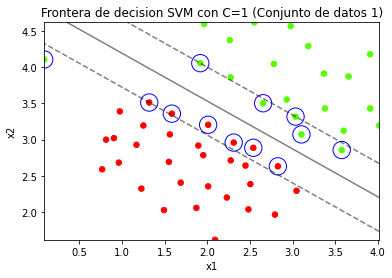

In [13]:
# Visualización del modelo
plt.title('Frontera de decision SVM con C=1 (Conjunto de datos 1)')
plt.margins(x=0, y=0)
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(X['x1'], X['x2'], c=y, s=30, cmap='prism');
plot_svc_decision_function(model)

A continuación, se probará diferentes valores de $C$ en este conjunto de datos. Específicamente con los valores $C = 20$ y $C = 100$.

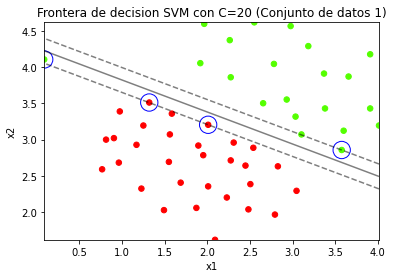

In [14]:
# Ajuste del modelo con C = 20 | aumentamos el valor de C
model20 = SVC(kernel='linear', C=20)
model20.fit(X, y)

# Visualización del modelo
plt.title('Frontera de decision SVM con C=20 (Conjunto de datos 1)')
plt.margins(x=0, y=0)
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(X['x1'], X['x2'], c=y, s=30, cmap='prism');
plot_svc_decision_function(model20) 

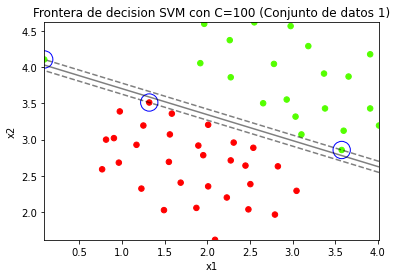

In [15]:
# Ajuste del modelo con C = 100
# Se acerca más a un Hard Margin!!!!
model100 = SVC(kernel='linear', C=100)
model100.fit(X, y)

# Visualización del modelo
plt.title('Frontera de decision SVM con C=100 (Conjunto de datos 1)')
plt.margins(x=0, y=0)
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(data1['x1'], data1['x2'], c=data1['y'], s=30, cmap='prism');
plot_svc_decision_function(model100) 

##Tarea

Conteste las siguientes preguntas:

**Pregunta 1:** ¿Cuántos vectores de soporte resultan al entrenar el modelo SVM con un kernel lineal y un valor $C = 20$?

**Pregunta 2:** En el modelo con $C = 20$, ¿se clasifica correctamente el valor atípico ubicado en $(0.1, 4.1)$?

**Pregunta 3:** ¿Cuántos vectores de soporte resultan al entrenar el modelo SVM con un kernel lineal y un valor $C = 100$?

**Pregunta 4:** En el modelo con $C = 100$, ¿se clasifica correctamente el valor atípico ubicado en $(0.1, 4.1)$?

**Pregunta 5:** ¿La frontera de decisión del modelo $C = 100$ coincide con la separación natural entre los datos? 


#### Respuestas:

Pregunta 1: El entrenamiento para una SVM de kernel lineal y valor C: 20 permite discernir 4 vectores de soporte (2 de etiqueta positiva-roja y 2 de etiqueta-negativa verde).

Pregunta 2: No. El valor atípico de coordenadas (0.1, 4.1) no se clasifica correctamente. Nótese cómo este punto ha excedido el valor límite de la frontera de decisión máxima (hard-margin) para la diferenciación de clases positivas y negativas. Esto normalmente suele deberse a una excesiva permisividad generada por los valores de distancia constitutivos del soft-margin a partir del valor C asignado.

Pregunta 3: El entrenamiento para una SVM de kernel linearl y valor C: 100 permite discernir 3 vectores de soporte (1 de etiqueta positiva-roja y 2 de etiqueta-negativa verde). 

Pregunta 4: Sí. El valor atípico de coornedadas (0.1, 4.1) sí se clasifica correctamente a partir del hard-magin definido. Nótese la diferencia con el escenario anterior. Aquí los boundaries generados por la distancia para el soft-margin son más cercanos al hard-margin. Esto se debe a un elevado valor C asignado (100 vs 20 para el caso anterior). En esa medida, esto permite un mayor acotamiento de los vectores de soporte y un mayor ajuste de los mismos a un horizonte cercano como frontera de decisión.

Pregunta 5: A nivel general, podría decirse que la frontera de decisión para una SVM con un kernel lineal y un valor C: 100 es más adecuada para los datos brindados. Esto, por supuesto, debido a que resulta menos permisivo para la inclusión/exclusión de valores atípicos como vectores soporte en los límites de las dos instancias. Por tanto, para los vectores de soporte brindados, resulta ser la más adecuada y natural. Sin embargo, nótese que el acotamiento de la distancia para los márgenes posee un nivel de failibilidad que ha de medirse OOF (out-of-sample). En esencia, un exceso en el acotamiento del mismo (es decir, valores de C muy bajos) puede generar estados de overfitting producto de este acotamiento.



## 2. SVM con kernel gaussiano

En esta parte del ejercicio usaremos SVMs para clasificación no lineal. Específicamente, usaremos SVMs con kernels gaussianos en conjuntos de datos que no son linealmente separables.

### 2.1. Conjunto de datos 2


In [16]:
data2 = pd.read_csv('ex6data2.csv', names=['x1', 'x2', 'y'])
X = data2[['x1', 'x2']]
y = data2['y']

data2.describe()

,x1,x2,y
count,863.000000,863.000000,863.000000
mean,0.503414,0.694304,0.556199
std,0.254967,0.158884,0.497120
min,0.044931,0.402630,0.000000
25%,0.292625,0.557020,0.000000
50%,0.512670,0.693710,1.000000
75%,0.699310,0.830410,1.000000
max,0.998850,0.988600,1.000000


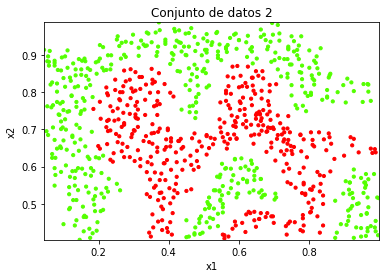

In [17]:
plt.title('Conjunto de datos 2')
plt.margins(x=0, y=0)
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(X['x1'], X['x2'], c=y, s=10, cmap='prism');

Podemos observar que en el conjunto de datos 2 no hay una frontera de decisión lineal que pueda separar los ejemplos positivos y negativos. Sin embargo, usando SVM con kernel gaussiano, se puede aprender una frontera de decisión no lineal que se desempeñe razonablemente bien en este conjunto de datos.

Antes de usar un kernel gaussiano, es importante normalizar el conjunto de datos $X$. Si bien en este caso $x_1$ y $x_2$ ya tienen un mismo rango $[0, 1]$, aplicaremos de todos modos un [escalador estándar](http://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling). El escalador estándar recibe $X$ y registra la media y desviación estándar, las cuales utilizará para transformar los datos. (Comparar con la estadística descriptiva dos pasos más arriba.)

In [18]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X)
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
scaler.mean_

array([0.5034135 , 0.69430429])

In [19]:
scaler.scale_

array([0.25481939, 0.15879163])

Para obtener los datos estandarizados, aplicamos la función `transform`:

In [20]:
X_scaled = scaler.transform(X)

`X_scaled` es un arreglo `numpy`. Usemos `pandas` para mostrar el sumario estadístico. Podemos verificar que los datos están normalizados con una media $\mu \approx 0$ y una desviación estándar $\sigma \approx 1$:

In [21]:
pd.DataFrame(X_scaled).describe()

,0,1
count,8.630000e+02,8.630000e+02
mean,-3.787366e-16,-6.900621e-16
std,1.000580e+00,1.000580e+00
min,-1.799245e+00,-1.836837e+00
25%,-8.272075e-01,-8.645562e-01
50%,3.632572e-02,-3.742561e-03
75%,7.687661e-01,8.571341e-01
max,1.944265e+00,1.853345e+00


Ahora sí ajustemos el modelo SVM con kernel gaussiano *(Radial Basis Function)*.

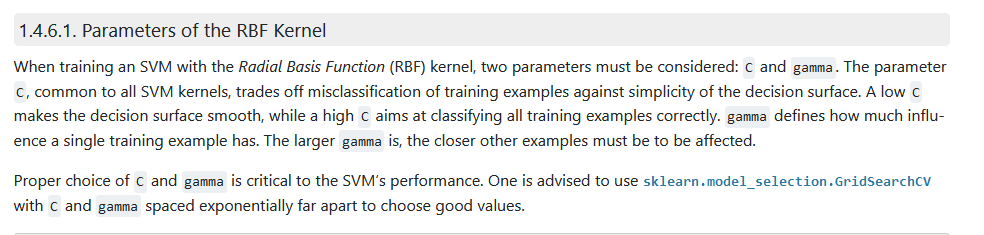

Recordar que en SMV SKLEARN puedes hacer tu propio kernel.

In [22]:
# Ajuste de modelo con kernel gaussiano
#RBF: GAUSSIANO
model = SVC(kernel='rbf', C=1, gamma=10)
model.fit(X_scaled, y)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Haremos la visualización con los datos normalizados. Dado que `X_scaled` es un arreglo `numpy`, accedemos a sus columnas $x_1$ y $x_2$ como `X_scaled[:,0]` y `X_scaled[:,1]`:

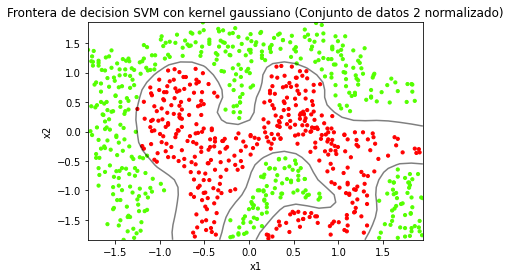

In [23]:
# Visualización
plt.title('Frontera de decision SVM con kernel gaussiano (Conjunto de datos 2 normalizado)')
plt.margins(x=0, y=0)
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=y, s=10, cmap='prism');
plot_svc_decision_function(model, plot_support=False, levels=[0], linestyles=['-']) 

En el ejemplo-gráfico anterior, el valor gamma permite ajustar más las fronteras. Entonces, para aumentar el ajuste, podremos aumentar C y aumentar Gamma. Sin embargo, lo ideal es balancear estos parámetros. Para ver este efecto, puede incrementar Gamma y C y ver cómo se ajustan más a los datos (pruebe con gamma = 1000 y vea el overfitting).

Por medio del método `score` podemos obtener la exactitud *(accuracy)* del modelo ajustado.

In [24]:
score = model.score(X_scaled, y)
tasa_de_error = (1- score)
n_ejemplos = len(X)
n_aciertos = score * len(X) 
n_errores = n_ejemplos - n_aciertos 

print ('Total de ejemplos: %d' % n_ejemplos)
print ('Exactitud: %0.4f' % score)
print ('Tasa de error: %0.4f' % tasa_de_error)
print ('Número de ejemplos correctamente clasificados: %d' % n_aciertos)
print ('Número de ejemplos incorrectamente clasificados: %d' % n_errores)


Total de ejemplos: 863
Exactitud: 0.9988
Tasa de error: 0.0012
Número de ejemplos correctamente clasificados: 862
Número de ejemplos incorrectamente clasificados: 1


### 2.2. Conjunto de datos 3

En esta parte del ejercicio vamos a aprender a seleccionar los parámetros $C$ y $\gamma$ requeridos por el kernel gaussiano.

La selección de los modelos de un parámetro se realiza por medio de *validación cruzada*. Para ello se reserva una muestra aleatoria del conjunto de datos que pueda servir para estimar el grado de generalización de los modelos a evaluar.

Para asegurar los mismos resultados, en este ejercicio recibimos directamente el conjunto de entrenamiento `(X, y)` y el conjunto de validación `(Xval, yval)`.

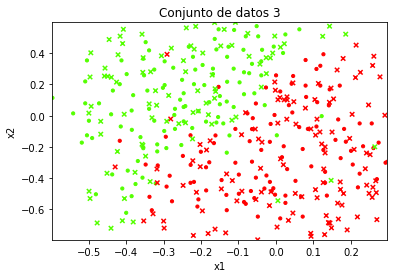

In [25]:
data3train = pd.read_csv('ex6data3train.csv', names=['x1', 'x2', 'y'])
X = data3train[['x1', 'x2']]
y = data3train['y']

data3val = pd.read_csv('ex6data3val.csv', names=['x1', 'x2', 'y'])
Xval = data3val[['x1', 'x2']]
yval = data3val['y']

plt.title('Conjunto de datos 3')
plt.margins(x=0, y=0)
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(X['x1'], X['x2'], c=y, s=10, cmap='prism', label='Conjunto de entrenamiento')
plt.scatter(Xval['x1'], Xval['x2'], c=yval, marker='x', s=20, cmap='prism', label='Conjunto de validacion')
plt.show()


Realizaremos también la normalización de los datos. Presta atención a que la normalización de los datos de validación $X_{val}$ se debe realizar con los parámetros obtenidos del conjunto de entrenamiento $X$.

In [26]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
Xval_scaled = scaler.transform(Xval)

Comparemos la exactitud en los conjuntos de entrenamiento y validación para un modelo con $C=200$ y $\gamma = 50$

In [27]:
model = SVC(kernel='rbf', C=200, gamma=50)
model.fit(X_scaled, y)

score_train = model.score(X_scaled, y)
score_val = model.score(Xval_scaled, yval)

print ('Exactitud en el conjunto de entrenamiento: %0.4f' % score_train)
print ('Exactitud en el conjunto de validación: %0.4f' % score_val)


Exactitud en el conjunto de entrenamiento: 1.0000
Exactitud en el conjunto de validación: 0.8800


Si bien se tiene una exactitud muy alta en el conjunto de entrenamiento, la exactitud es bastante menor en el conjunto de validación. Este es un síntoma claro de sobreajuste *(overfitting)*. Visualicemos lo que está ocurriendo.

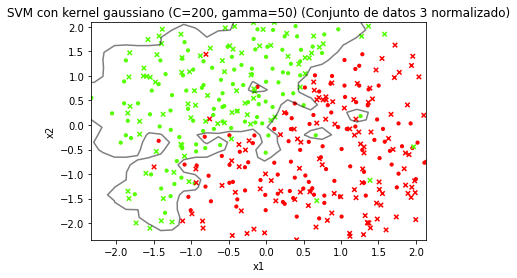

In [28]:
# Visualización
# Nótese cómo un C alto y un Gamma alto ha generado "islas" | OVERFITTING
plt.title('SVM con kernel gaussiano (C=200, gamma=50) (Conjunto de datos 3 normalizado)')
plt.margins(x=0, y=0)
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=y, s=10, cmap='prism', label='Conjunto de entrenamiento')
plt.scatter(Xval_scaled[:,0], Xval_scaled[:,1], c=yval, marker='x', s=20, cmap='prism', label='Conjunto de validacion')
plot_svc_decision_function(model, plot_support=False, levels=[0], linestyles=['-']) 


Podemos apreciar visualmente que la generalización es deficiente porque el modelo está **"memorizando"** la ubicación de los valores atípicos. Este no es un comportamiento deseable.

**¿Cómo determinar el mejor C y el mejor gamma?**

Para determinar valores $C$ y $\gamma$ que brinden una mejor generalización, es necesario probar con diferentes valores, ajustando el modelo en el conjunto de entrenamiento y probando su desempeño en el conjunto de validación. Esta estratégia se conoce como grid search.

Probemos con Poly:

Exactitud en el conjunto de entrenamiento: 0.9289
Exactitud en el conjunto de validación: 0.9200


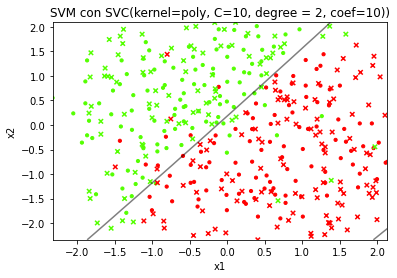

In [29]:
model = SVC(kernel='poly', C=10, degree = 2, coef0=10)
model.fit(X_scaled, y)

score_train = model.score(X_scaled, y)
score_val = model.score(Xval_scaled, yval)

print ('Exactitud en el conjunto de entrenamiento: %0.4f' % score_train)
print ('Exactitud en el conjunto de validación: %0.4f' % score_val)

# Visualización
# Nótese cómo un C alto y un Gamma alto ha generado "islas" | OVERFITTING
plt.title('SVM con SVC(kernel=poly, C=10, degree = 2, coef=10))')
plt.margins(x=0, y=0)
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=y, s=10, cmap='prism', label='Conjunto de entrenamiento')
plt.scatter(Xval_scaled[:,0], Xval_scaled[:,1], c=yval, marker='x', s=20, cmap='prism', label='Conjunto de validacion')
plot_svc_decision_function(model, plot_support=False, levels=[0], linestyles=['-']) 


Mejor valor de C: 1.0000
Mejor valor de gamma: 2.7826
Exactitud en el conjunto de entrenamiento: 0.9431
Exactitud en el conjunto de validación: 0.9600


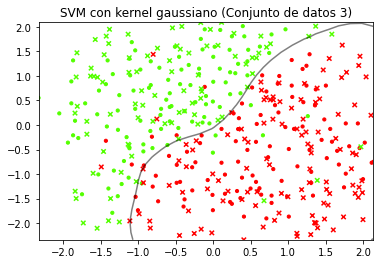

In [54]:
Cs = np.logspace(-4,4,9)  # ~ [0.01, 0.03, 0.1, ..., 100]
gammas = np.logspace(-4,4,10)  # [0.0001, 0.001, ..., 10000]
#gammas = np.logspace(-4,4,9)


mejor_modelo = None
mejor_score = 0
for C in Cs:
    for gamma in gammas:
        
        model = SVC(kernel='rbf', C=C, gamma=gamma) 
        model.fit(X_scaled, y)
        
        score_val = model.score(Xval_scaled, yval) 
        
        if score_val > mejor_score:
            mejor_score = score_val
            mejor_modelo = model


print ('Mejor valor de C: %0.4f' % mejor_modelo.get_params()['C'])
print ('Mejor valor de gamma: %0.4f' % mejor_modelo.get_params()['gamma'])
print ('Exactitud en el conjunto de entrenamiento: %0.4f' % mejor_modelo.score(X_scaled, y))
print ('Exactitud en el conjunto de validación: %0.4f' % mejor_modelo.score(Xval_scaled, yval))

# Visualización
plt.title('SVM con kernel gaussiano (Conjunto de datos 3)')
plt.margins(x=0, y=0)
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=y, s=10, cmap='prism', label='Conjunto de entrenamiento')
plt.scatter(Xval_scaled[:,0], Xval_scaled[:,1], c=yval, marker='x', s=20, cmap='prism', label='Conjunto de validacion')
plot_svc_decision_function(mejor_modelo, plot_support=False, levels=[0], linestyles=['-']) 


Observe la forma de la frontera de decisión de su mejor modelo y compárela con la obtenida arriba con $C=200$ y $\gamma = 50$. Luego responda las siguientes preguntas sobre el mejor modelo:

## TAREA

**Pregunta 6:** ¿Cuál fue el mejor valor de $C$ obtenido? ¿Cuál fue el mejor valor de $\gamma$ obtenido?

**Pregunta 7:** ¿Se obtuvo una mejor exactitud en el conjunto de entrenamiento o en el conjunto de validación?

**Pregunta 8:** Comente las gráficas de las funciones de decisión en relación a los parámetros parámetro C y gamma.

## Respuestas

Pregunta 6: En la iteración para el modelo SVM de kernel Gaussiano (_Radian Basis Function_) se encontró que el mejor valor de C era 1 y el mejor gamma 10.00. Sin embargo, se hizo una experimentación adicional cambiando los posibles valores de búsqueda originales. Se probó con las siguientes combinaciones:

- `Cs = np.logspace(-4,4,10)`
- `gammas = np.logspace(-4,4,10)`

A partir de estos cambios, se encontró probablemente una forma mejorada de segmentación de las dos instancias de los datos.

De ese modo, se pasó de esto:

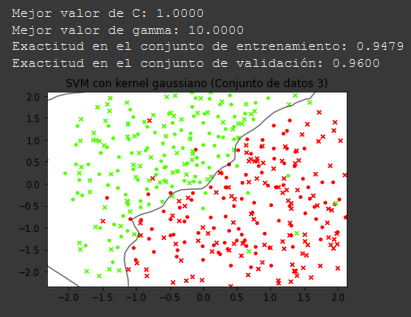

A esto:

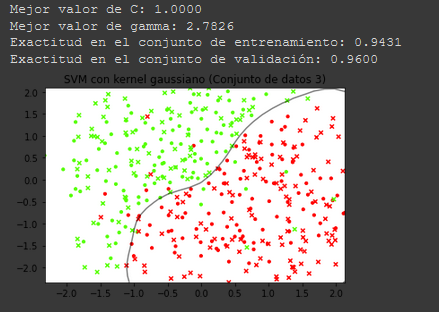

Esto brindaba un valor de C = 1 y, a diferencia de la anterior, un valor ideal de gamma = 2.78.



Pregunta 7: para ambas pruebas, se obtuvo una mayor exactitud en el conjunto de datos de validación que en los de entrenamiento. Esto constituye de primera improta una buena señal de que los límites de decisión fueron adecuadamente definidos.

Pregunta 8:

La idea central sería, bajo estos dos escenarios comparativos, definir el valor C y el valor gamma. El valor C es el mismo para ambos casos: 1. Resultará necesario definir la elección del valor gamma: 10 para la primera prueba y 2.78 para la segunda, con scores de validación idénticos. Así, el _score_ bajó un poco en el conjunto de entrenamiento para la segunda prueba (0.9479 vs 0.9431). Sin embargo, debido a que se mantuvo el score en el conjunto de validación (0.96) para ambos casos, se prefirió elegir esta nueva combinatoria: valor C = 1 y gamma = 2.78. Existen dos razones: (1) debido a que la forma del boundary que divide las dos instancias es mucho más natural, curva y menos adherida a un grupo específico de vectores de soporte que en la versión primogénita; y (2) debido al valor gamma bajo versus un gamma casi cinco veces mayor. 

No es regla generalizada; sin embargo, un valor gamma bajo calibra en menor grado la influencia de un valor individual sobre sus vecinos (campana más ancha). En esa medida, al entenderse este como un regulador del ancho de campana de la función similitud, permite un mayor grado de permisividad para la clasificación de los valores y una menor probabilidad de overfitting si y solo el resultado de este valor gamma menor es comparable con otro valor gamma más alto. Teniendo estas dos pruebas, se prefirió la segunda debido a que otorgaba el mismo score para el OOF con un valor gamma más bajo.

# Aplicaciones prácticas: Breast Cancer

Carga de datos y separación en conjuntos de entrenamiento y validación.

In [55]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

data = load_breast_cancer()
Xtrain, Xtest, Ytrain, Ytest = train_test_split(data.data, data.target, test_size=0.33)

Preprocesamiento de datos

In [56]:
scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

Entrenamiento del modelo y obtención del score.

In [57]:
model = SVC(kernel='rbf',C=4., gamma=.05)
model.fit(Xtrain, Ytrain)
print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))

train score: 0.994750656167979
test score: 0.9361702127659575


Exploración de otras métricas (precision, recall, f1-score):

In [58]:
from sklearn.metrics import classification_report
Ypred = model.predict(Xtest)

In [59]:
print(classification_report(Ytest,Ypred))

#recall: de todo el universo de una clase, cuantas pude detectar o recuperar

              precision    recall  f1-score   support

           0       0.89      0.94      0.92        71
           1       0.96      0.93      0.95       117

    accuracy                           0.94       188
   macro avg       0.93      0.94      0.93       188
weighted avg       0.94      0.94      0.94       188



Pruebas con kernel linear

In [60]:
model = SVC(kernel='linear',C=4.)
model.fit(Xtrain, Ytrain)
print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))

train score: 0.994750656167979
test score: 0.9574468085106383


Pruebas con kernel polinomial de grados 2, 3 y 4

In [61]:
model = SVC(kernel='poly',C=4.,degree=2) #GRADOS 
model.fit(Xtrain, Ytrain)
print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))

train score: 0.8871391076115486
test score: 0.8138297872340425


In [62]:
model = SVC(kernel='poly',C=4.,degree=3)
model.fit(Xtrain, Ytrain)
print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))

train score: 0.958005249343832
test score: 0.9148936170212766


In [65]:
model = SVC(kernel='poly',C=4.,degree=4)
model.fit(Xtrain, Ytrain)
print("train score:", model.score(Xtrain, Ytrain))
print("test score:", model.score(Xtest, Ytest))

train score: 0.8766404199475065
test score: 0.7925531914893617


## TAREA - EXPERIMENTAR PARA ENCONTRAR EL MEJOR 'C' Y EL MEJOR 'GAMMA' PARA UN KERNEL GAUSSIANO

**Pregunta 9:** Se ha definido un conjunto de valores para C y gamma. Implemente un grid search para encontrar el mejor par de hiperparámetros (C, gamma) para un modelo SVM con kernel gaussiano.

Resultado
 
Mejor modelo:
SVC(C=10.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
 
Mejor valor de C: 10.0000
Mejor valor de gamma: 0.0010
Exactitud en el conjunto de entrenamiento: 0.97375328
Exactitud en el conjunto de validación: 0.97340426


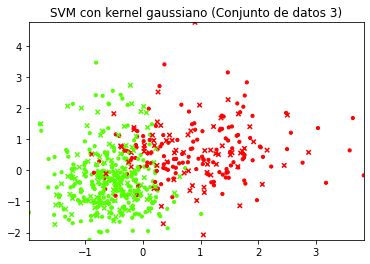

In [123]:
Cs = np.logspace(-2,2,9)  # ~ [0.01, 0.03, 0.1, ..., 100]
gammas = np.logspace(-4,4,9)  # [0.0001, 0.001, ..., 10000]

mejor_modelo_ = None
mejor_score_ = 0.0

for C in Cs:
  for gamma in gammas:
    model = SVC(kernel='rbf', C=C, gamma=gamma) 
    model.fit(Xtrain, Ytrain)
        
    score_val = model.score(Xtest, Ytest) 
    if score_val > mejor_score_:
      mejor_score_ = score_val
      mejor_modelo_ = model


# Visualización
print("Resultado")
plt.title('SVM con kernel gaussiano (Conjunto de datos 3)')
plt.margins(x=0, y=0)
plt.scatter(Xtrain[:,0], Xtrain[:,1], c=Ytrain, s=10, cmap='prism', label='Conjunto de entrenamiento')
plt.scatter(Xtest[:,0], Xtest[:,1], c=Ytest, marker='x', s=20, cmap='prism', label='Conjunto de validacion')
plt.plot()
print(" ")


print("Mejor modelo:")
print(mejor_modelo_)
print(" ")

print ('Mejor valor de C: %0.4f' % mejor_modelo_.get_params()['C'])
print ('Mejor valor de gamma: %0.4f' % mejor_modelo_.get_params()['gamma'])
print ('Exactitud en el conjunto de entrenamiento: %0.8f' % mejor_modelo_.score(Xtrain, Ytrain))
print ('Exactitud en el conjunto de validación: %0.8f' % mejor_modelo_.score(Xtest, Ytest))